# アブストラクトの評価指標に関する分析

### 目的

- 良い論文と悪い論文の間で評価指標（rule1 ~ rule31）の差を分析。
- 2 グループ間の有意差を検証。


# データの読み込み


In [412]:
# 必要なライブラリをインポート
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.stats.proportion import proportions_ztest

In [413]:
import matplotlib.font_manager as fm

# 使用可能なフォントをリスト表示
available_fonts = sorted([f.name for f in fm.fontManager.ttflist])
print("使用可能なフォント:", available_fonts)

使用可能なフォント: ['.Aqua Kana', '.Keyboard', '.New York', '.New York', '.SF Arabic', '.SF Arabic Rounded', '.SF Armenian', '.SF Armenian Rounded', '.SF Camera', '.SF Compact Rounded', '.SF Georgian', '.SF Georgian Rounded', '.SF Hebrew', '.SF Hebrew Rounded', '.SF NS Mono', '.SF NS Rounded', '.SF Soft Numeric', '.ThonburiUI', 'Academy Engraved LET', 'Al Bayan', 'Al Nile', 'Al Tarikh', 'American Typewriter', 'Andale Mono', 'Apple Braille', 'Apple Braille', 'Apple Braille', 'Apple Braille', 'Apple Braille', 'Apple Chancery', 'Apple LiGothic', 'Apple LiSung', 'Apple SD Gothic Neo', 'Apple Symbols', 'AppleGothic', 'AppleMyungjo', 'Arial', 'Arial', 'Arial', 'Arial', 'Arial Black', 'Arial Hebrew', 'Arial Narrow', 'Arial Narrow', 'Arial Narrow', 'Arial Narrow', 'Arial Rounded MT Bold', 'Arial Unicode MS', 'Arial Unicode MS', 'Athelas', 'Avenir', 'Avenir Next', 'Avenir Next Condensed', 'Ayuthaya', 'BIZ UDGothic', 'BIZ UDMincho', 'BM Dohyeon', 'BM Hanna 11yrs Old', 'BM Hanna Air', 'BM Hanna Pro', 'BM

In [414]:
data_dir = "../../data/results/combined"

high_group = {}
low_group = {}

# フォルダ内のすべてのファイルを探索
for filename in os.listdir(data_dir):
    if filename.endswith(".csv"):  # CSVファイルのみを対象
        # ファイルパスを作成
        file_path = os.path.join(data_dir, filename)

        # 分野名を抽出（例: "Biochemistry_Molecular_Biology"）
        field = filename.split("_high")[0] if "_high" in filename else filename.split("_low")[0]

        # データを読み込み
        df = pd.read_csv(file_path)

        # high または low グループに振り分け
        if "_high" in filename:
            high_group[field] = df
        elif "_low" in filename:
            low_group[field] = df


# データの前処理


In [415]:
# データ前処理を関数として定義
def preprocess_data(df, rules):
    # 1. Abstractが欠損している行を削除
    print(f"Before dropping rows with missing Abstract: {len(df)} rows")
    df.dropna(subset=['Abstract'], inplace=True)
    print(f"After dropping rows with missing Abstract: {len(df)} rows")

    # 2. 欠損値の確認と補完（rule列）
    print("欠損値の確認（その他の列）:")
    missing_values = df.isnull().sum()
    print(missing_values[missing_values > 0])  # 残りの欠損値を表示
    df.fillna('no', inplace=True)  # ルール列の欠損値を 'no' で補完

    # 3. データ型の確認
    print("\nデータ型の確認:")
    print(df.dtypes)

    # 4. 不要な列の削除（例: 'ID', 'Title' など）
    df.drop(columns=['ID', 'Title', 'Authors', 'Publication Type', 'DOI'], inplace=True, errors='ignore')  # 必要に応じて調整

    # 5. 前処理結果を返す
    return df

# すべてのデータフレームを前処理
rules = [f'rule{i}' for i in range(1, 32)]

# データの確認


In [416]:
# データの基本情報を表示する関数
def summarize_data(df, group_name):
    print(f"\n--- {group_name} ---")
    # データサイズ
    print(f"データサイズ: {df.shape[0]} 行, {df.shape[1]} 列")
    
    # 欠損値の確認
    print("\n欠損値:")
    print(df.isnull().sum()[df.isnull().sum() > 0])

    # データ型
    print("\nデータ型:")
    print(df.dtypes)

    # yes/no の頻度
    print("\n各ルールのyes/noの分布:")
    rules = [col for col in df.columns if col.startswith('rule')]
    for rule in rules:
        print(f"{rule}:")
        print(df[rule].value_counts())


In [417]:
# 高頻度グループのデータを確認
for field, df in high_group.items():
    summarize_data(df, f"High Group: {field}")

# 低頻度グループのデータを確認
for field, df in low_group.items():
    summarize_data(df, f"Low Group: {field}")



--- High Group: Biochemistry_Molecular_Biology ---
データサイズ: 1000 行, 37 列

欠損値:
Abstract      3
DOI           2
rule1        50
rule2        50
rule3        50
rule4        50
rule5        50
rule6        50
rule7        50
rule8        50
rule9        50
rule10       50
rule11       50
rule12       50
rule13       50
rule14       50
rule15       50
rule16       50
rule17       50
rule18       50
rule19       50
rule20       50
rule21       50
rule22       50
rule23       50
rule24       50
rule25       50
rule26       50
rule27       50
rule28       50
rule29       54
rule30       54
rule31      344
dtype: int64

データ型:
Publication Type    object
Authors             object
Title               object
Abstract            object
DOI                 object
ID                   int64
rule1               object
rule2               object
rule3               object
rule4               object
rule5               object
rule6               object
rule7               object
rule8               ob

# データの分析


## 全体での比較


### Yes の割合


In [418]:
# 全体のhighとlowを結合
combined_high = pd.concat(high_group.values(), ignore_index=True)
combined_low = pd.concat(low_group.values(), ignore_index=True)

print(f"Combined High: {combined_high.shape}")
print(f"Combined Low: {combined_low.shape}")


Combined High: (5000, 37)
Combined Low: (5000, 37)


In [419]:
rules = [f'rule{i}' for i in range(1, 32)]

# 全体の比較結果を格納
overall_results = []

for rule in rules:
    high_yes = (combined_high[rule] == 'yes').sum()
    low_yes = (combined_low[rule] == 'yes').sum()

    high_total = len(combined_high)
    low_total = len(combined_low)

    high_ratio = high_yes / high_total
    low_ratio = low_yes / low_total

    # 結果を保存
    overall_results.append({
        'Rule': rule,
        'High Ratio': high_ratio,
        'Low Ratio': low_ratio
    })

# データフレーム化して表示
overall_df = pd.DataFrame(overall_results)
print(overall_df)


      Rule  High Ratio  Low Ratio
0    rule1      0.8864     0.8444
1    rule2      0.5030     0.4844
2    rule3      0.2110     0.1872
3    rule4      0.4990     0.2968
4    rule5      0.7730     0.7828
5    rule6      0.1252     0.1352
6    rule7      0.7096     0.7016
7    rule8      0.4542     0.2900
8    rule9      0.3880     0.5722
9   rule10      0.1730     0.1860
10  rule11      0.8908     0.8748
11  rule12      0.5820     0.7206
12  rule13      0.2914     0.2678
13  rule14      0.1588     0.2942
14  rule15      0.0778     0.1520
15  rule16      0.3952     0.4240
16  rule17      0.7124     0.7660
17  rule18      0.6638     0.7202
18  rule19      0.4928     0.3238
19  rule20      0.2982     0.5056
20  rule21      0.1550     0.2982
21  rule22      0.0916     0.2168
22  rule23      0.2904     0.3230
23  rule24      0.6250     0.6468
24  rule25      0.6724     0.6744
25  rule26      0.5852     0.4862
26  rule27      0.4342     0.2556
27  rule28      0.3352     0.1862
28  rule29    

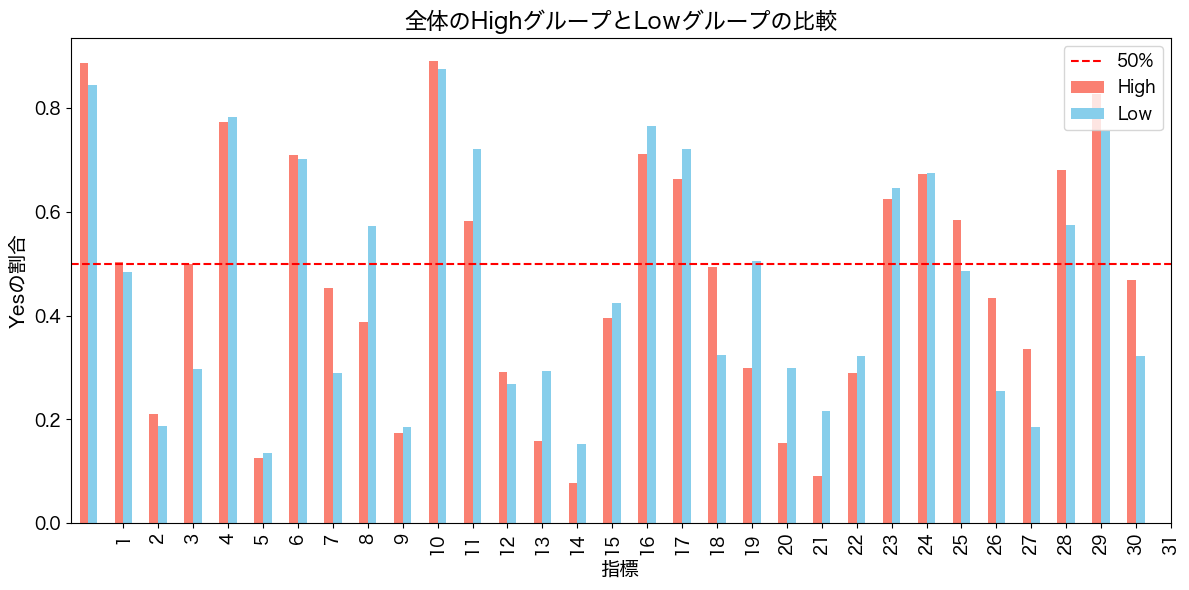

In [420]:
# 日本語フォントの設定
plt.rcParams['font.family'] = 'Hiragino Sans'

# Rule列を数値に変換
overall_df['Rule'] = overall_df['Rule'].str.replace('rule', '').astype(int)

# グラフ描画
overall_df.plot(
    x='Rule', 
    y=['High Ratio', 'Low Ratio'], 
    kind='bar', 
    figsize=(12, 6), 
    color=['salmon', 'skyblue']
)

plt.title('全体のHighグループとLowグループの比較', fontsize=16)  # グラフのタイトル
plt.xlabel('指標', fontsize=14)  # x軸ラベル
plt.ylabel('Yesの割合', fontsize=14)  # y軸ラベル

plt.xticks(ticks=overall_df['Rule'], labels=overall_df['Rule'], fontsize=12)
plt.yticks(fontsize=12)  # y軸目盛りラベルのサイズ

# 50%基準線を追加
plt.axhline(y=0.5, color='red', linestyle='--', label='50% 基準線')

# 凡例の日本語化
plt.legend(['50%', 'High', 'Low'], fontsize=12)

# レイアウト調整
plt.tight_layout()

# グラフを表示
plt.show()


### Z 検定


In [421]:
# Z検定結果を格納
overall_results = []

rules = [f'rule{i}' for i in range(1, 32)]

for rule in rules:
    high_yes = (combined_high[rule] == 'yes').sum()
    low_yes = (combined_low[rule] == 'yes').sum()

    high_total = len(combined_high)
    low_total = len(combined_low)

    # Z検定の実行
    count = [high_yes, low_yes]
    nobs = [high_total, low_total]
    stat, p_value = proportions_ztest(count, nobs, alternative='two-sided')

    # 結果を保存
    overall_results.append({'Rule': rule, 'Z-statistic': stat, 'P-value': p_value})

# データフレーム化して表示
overall_df = pd.DataFrame(overall_results)
print("Overall Z-test Results:")
print(overall_df)


Overall Z-test Results:
      Rule  Z-statistic       P-value
0    rule1     6.153020  7.602126e-10
1    rule2     1.860148  6.286464e-02
2    rule3     2.980041  2.882102e-03
3    rule4    20.655222  8.761707e-95
4    rule5    -1.178854  2.384564e-01
5    rule6    -1.485781  1.373370e-01
6    rule7     0.877631  3.801442e-01
7    rule8    16.985099  1.058750e-64
8    rule9   -18.434606  6.932142e-76
9   rule10    -1.693721  9.031834e-02
10  rule11     2.487110  1.287855e-02
11  rule12   -14.541752  6.588496e-48
12  rule13     2.629218  8.558152e-03
13  rule14   -16.174259  7.661335e-59
14  rule15   -11.633696  2.778020e-31
15  rule16    -2.928258  3.408670e-03
16  rule17    -6.103796  1.035784e-09
17  rule18    -6.108305  1.006949e-09
18  rule19    17.191597  3.069567e-66
19  rule20   -21.151095  2.696116e-99
20  rule21   -17.103342  1.401325e-65
21  rule22   -17.333981  2.606475e-67
22  rule23    -3.534843  4.080177e-04
23  rule24    -2.265279  2.349555e-02
24  rule25    -0.213233  8

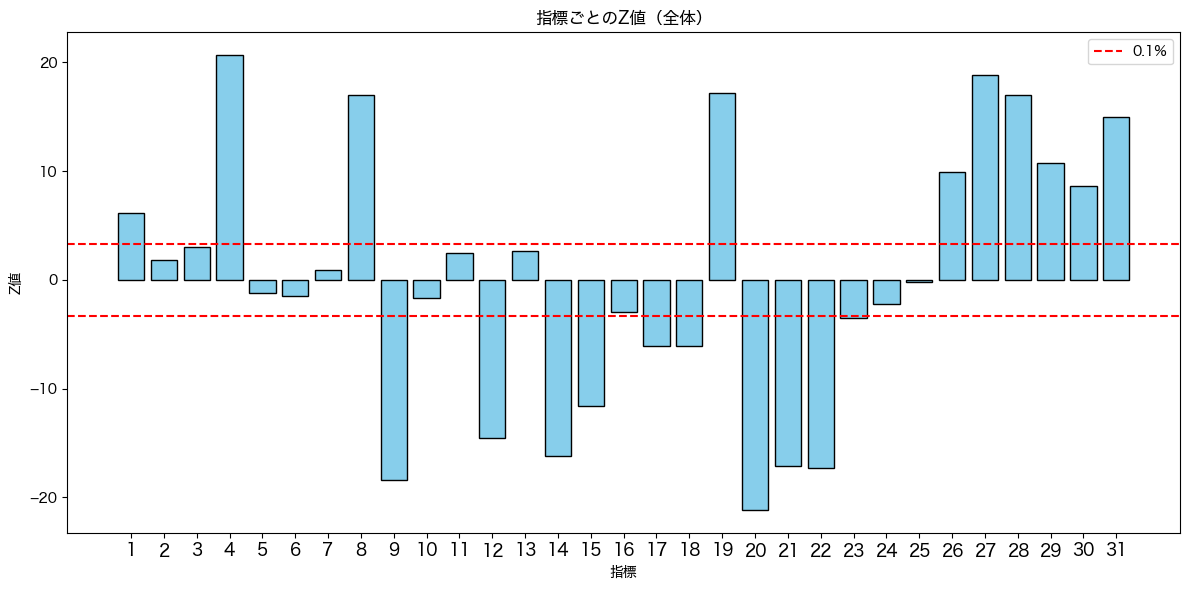

In [422]:
# 全体のZ値をプロット

# Rule列を数値に変換
overall_df['Rule'] = overall_df['Rule'].str.replace('rule', '').astype(int)

plt.figure(figsize=(12, 6))
plt.bar(overall_df['Rule'], overall_df['Z-statistic'], color='skyblue', edgecolor='black')

plt.axhline(y=3.29, color='red', linestyle='--', label='0.1% 有意水準 (+3.29)')
plt.axhline(y=-3.29, color='red', linestyle='--', label='0.1% 有意水準 (-3.29)')

plt.title('指標ごとのZ値（全体）')
plt.ylabel('Z値')
plt.xlabel('指標')
# 横軸の値をすべて表示
plt.xticks(ticks=overall_df['Rule'], labels=overall_df['Rule'], fontsize=12)

plt.legend()
plt.tight_layout()
plt.show()


## 分野ごとの比較


### Yes の割合


In [423]:
# 各分野の比較結果を保存
field_results = []

for field in high_group.keys():
    high_df = high_group[field]
    low_df = low_group[field]

    for rule in rules:
        high_yes = (high_df[rule] == 'yes').sum()
        low_yes = (low_df[rule] == 'yes').sum()

        high_total = len(high_df)
        low_total = len(low_df)

        high_ratio = high_yes / high_total
        low_ratio = low_yes / low_total

        # 結果を保存
        field_results.append({
            'Field': field,
            'Rule': rule,
            'High Ratio': high_ratio,
            'Low Ratio': low_ratio
        })

# データフレーム化して表示
field_df = pd.DataFrame(field_results)
print(field_df)


                              Field    Rule  High Ratio  Low Ratio
0    Biochemistry_Molecular_Biology   rule1       0.946      0.851
1    Biochemistry_Molecular_Biology   rule2       0.499      0.283
2    Biochemistry_Molecular_Biology   rule3       0.294      0.366
3    Biochemistry_Molecular_Biology   rule4       0.575      0.429
4    Biochemistry_Molecular_Biology   rule5       0.839      0.810
..                              ...     ...         ...        ...
150                     Engineering  rule27       0.482      0.341
151                     Engineering  rule28       0.320      0.178
152                     Engineering  rule29       0.602      0.482
153                     Engineering  rule30       0.783      0.758
154                     Engineering  rule31       0.493      0.342

[155 rows x 4 columns]


/var/folders/kb/fcmv44k11vvczn4k2qxly51c0000gn/T/ipykernel_71587/4072320935.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  field_subset['Rule'] = field_subset['Rule'].str.replace('rule', '').astype(int)


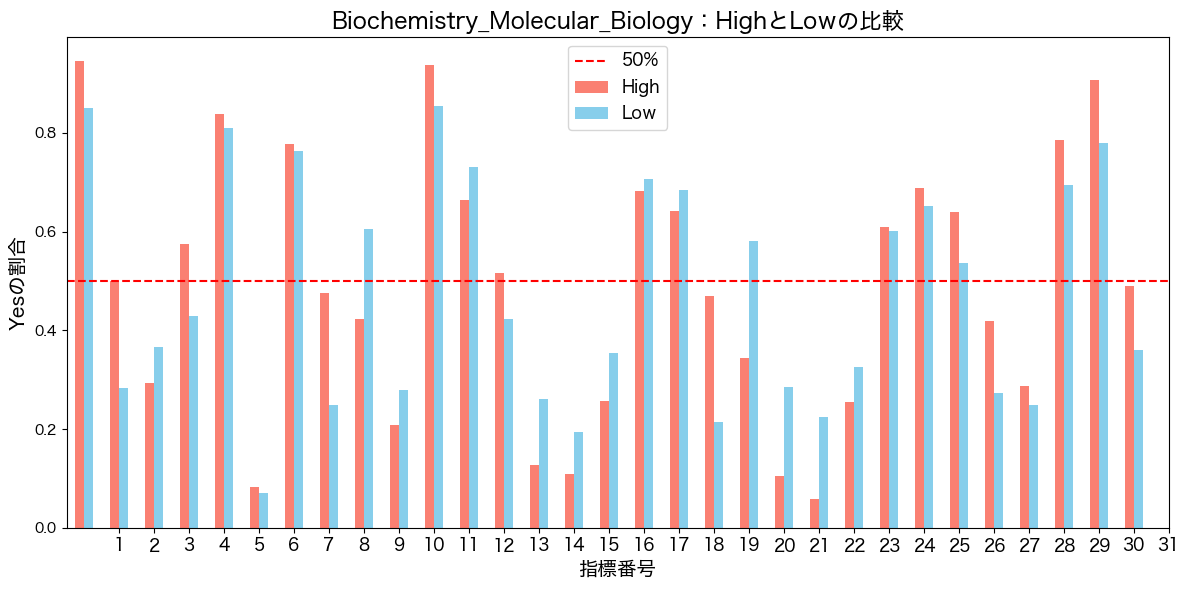

/var/folders/kb/fcmv44k11vvczn4k2qxly51c0000gn/T/ipykernel_71587/4072320935.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  field_subset['Rule'] = field_subset['Rule'].str.replace('rule', '').astype(int)


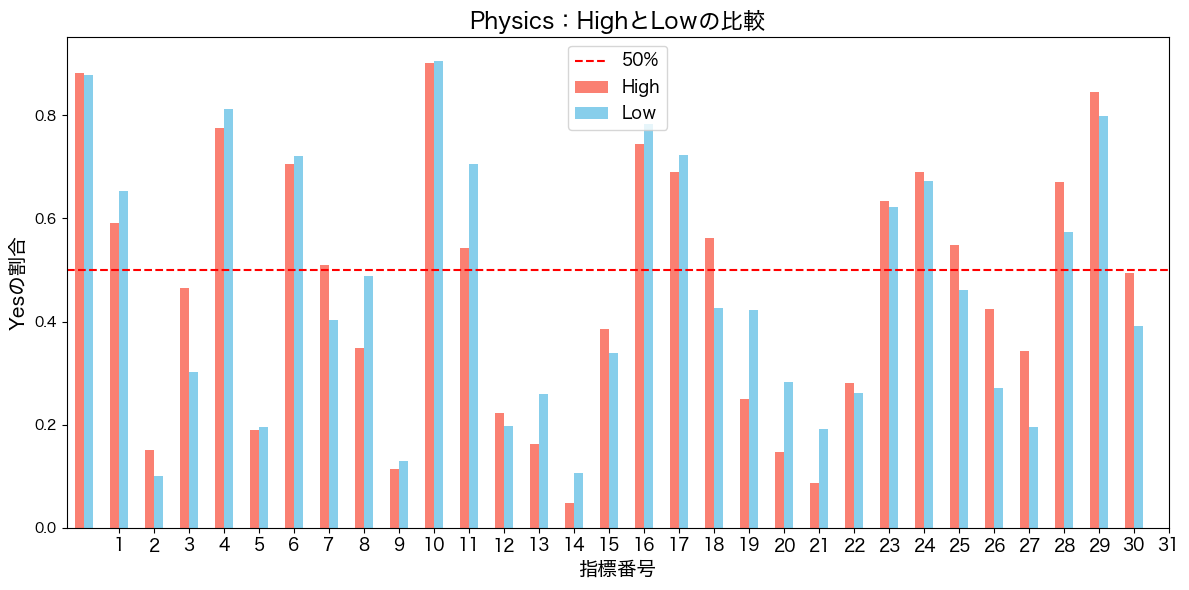

/var/folders/kb/fcmv44k11vvczn4k2qxly51c0000gn/T/ipykernel_71587/4072320935.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  field_subset['Rule'] = field_subset['Rule'].str.replace('rule', '').astype(int)


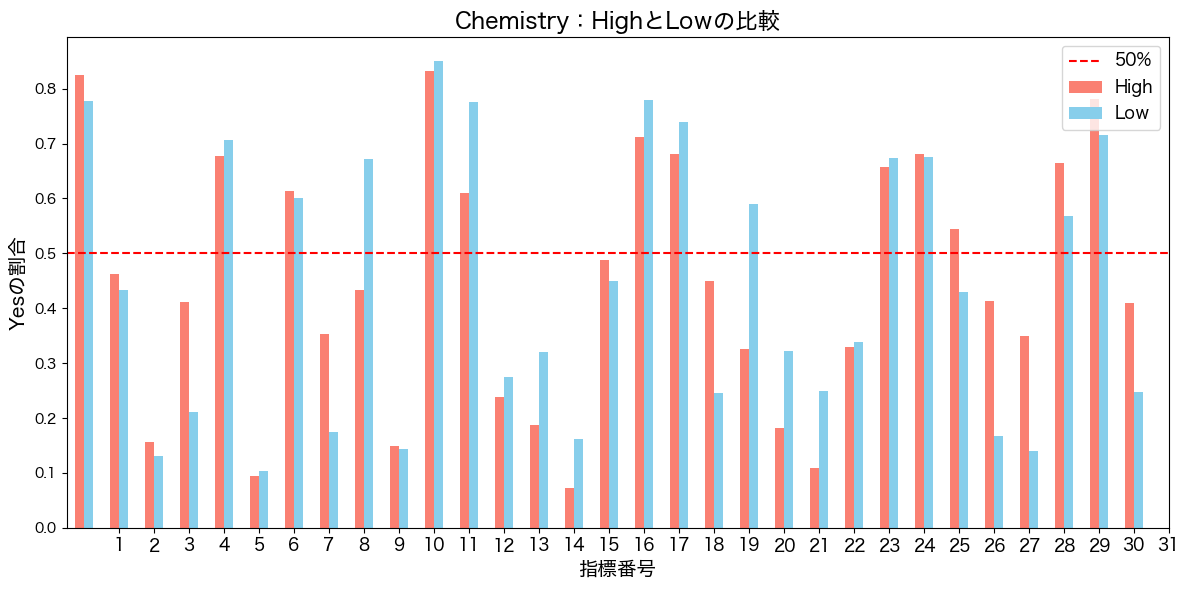

/var/folders/kb/fcmv44k11vvczn4k2qxly51c0000gn/T/ipykernel_71587/4072320935.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  field_subset['Rule'] = field_subset['Rule'].str.replace('rule', '').astype(int)


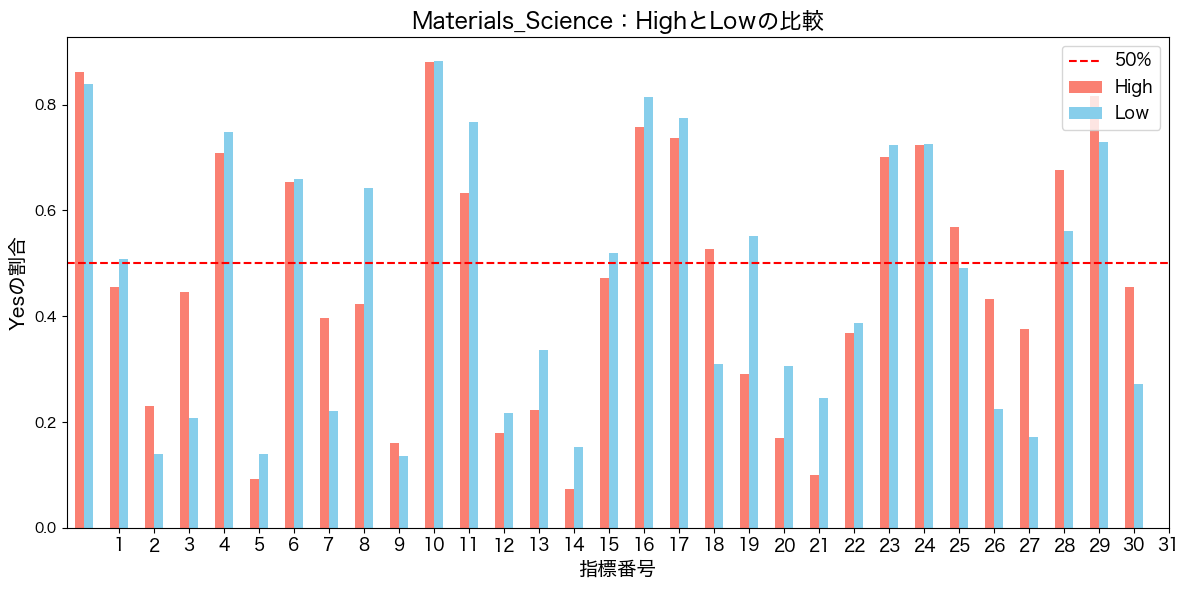

/var/folders/kb/fcmv44k11vvczn4k2qxly51c0000gn/T/ipykernel_71587/4072320935.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  field_subset['Rule'] = field_subset['Rule'].str.replace('rule', '').astype(int)


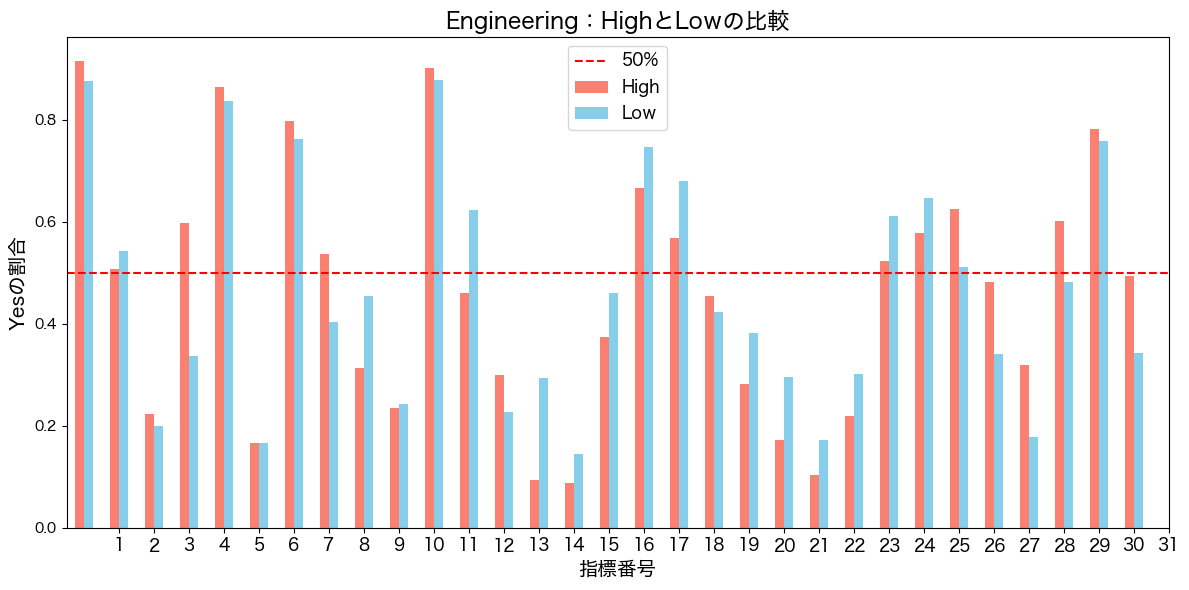

In [424]:
# 分野ごとの可視化
for field in high_group.keys():
    # 該当分野のデータを取得
    field_subset = field_df[field_df['Field'] == field]

    # Rule列を数値化（横軸を数字のみにする）
    field_subset['Rule'] = field_subset['Rule'].str.replace('rule', '').astype(int)

    # グラフ描画
    field_subset.plot(
        x='Rule', 
        y=['High Ratio', 'Low Ratio'], 
        kind='bar', 
        figsize=(12, 6), 
        color=['salmon', 'skyblue']
    )
    
    # 日本語ラベルの設定
    plt.title(f'{field}：HighとLowの比較', fontsize=16)  # グラフのタイトル
    plt.xlabel('指標番号', fontsize=14)  # x軸ラベル
    plt.ylabel('Yesの割合', fontsize=14)  # y軸ラベル

    # x軸目盛りを数字のみにしてすべて表示
    plt.xticks(ticks=field_subset['Rule'], labels=field_subset['Rule'], rotation=0, fontsize=12)
    
    # 50%基準線
    plt.axhline(y=0.5, color='red', linestyle='--', label='50% 基準線')

    # 凡例の設定
    plt.legend(['50%', 'High', 'Low'], fontsize=12)

    # レイアウト調整
    plt.tight_layout()
    
    # グラフ表示
    plt.show()


### Z 検定


In [425]:
# 分野ごとのZ検定結果を格納
field_results = []

for field in high_group.keys():
    high_df = high_group[field]
    low_df = low_group[field]

    for rule in rules:
        high_yes = (high_df[rule] == 'yes').sum()
        low_yes = (low_df[rule] == 'yes').sum()

        high_total = len(high_df)
        low_total = len(low_df)

        # Z検定の実行
        count = [high_yes, low_yes]
        nobs = [high_total, low_total]
        stat, p_value = proportions_ztest(count, nobs, alternative='two-sided')

        # 結果を保存
        field_results.append({
            'Field': field,
            'Rule': rule,
            'Z-statistic': stat,
            'P-value': p_value
        })

# データフレーム化して表示
field_df = pd.DataFrame(field_results)
print("\nField-wise Z-test Results:")
print(field_df)



Field-wise Z-test Results:
                              Field    Rule  Z-statistic       P-value
0    Biochemistry_Molecular_Biology   rule1     7.034230  2.003648e-12
1    Biochemistry_Molecular_Biology   rule2     9.897870  4.252366e-23
2    Biochemistry_Molecular_Biology   rule3    -3.423916  6.172565e-04
3    Biochemistry_Molecular_Biology   rule4     6.529371  6.604659e-11
4    Biochemistry_Molecular_Biology   rule5     1.704705  8.824955e-02
..                              ...     ...          ...           ...
150                     Engineering  rule27     6.406871  1.485367e-10
151                     Engineering  rule28     7.342665  2.093824e-13
152                     Engineering  rule29     5.385597  7.220451e-08
153                     Engineering  rule30     1.329375  1.837244e-01
154                     Engineering  rule31     6.846770  7.553597e-12

[155 rows x 4 columns]


/var/folders/kb/fcmv44k11vvczn4k2qxly51c0000gn/T/ipykernel_71587/1402931054.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  field_subset['Rule'] = field_subset['Rule'].str.replace('rule', '').astype(int)


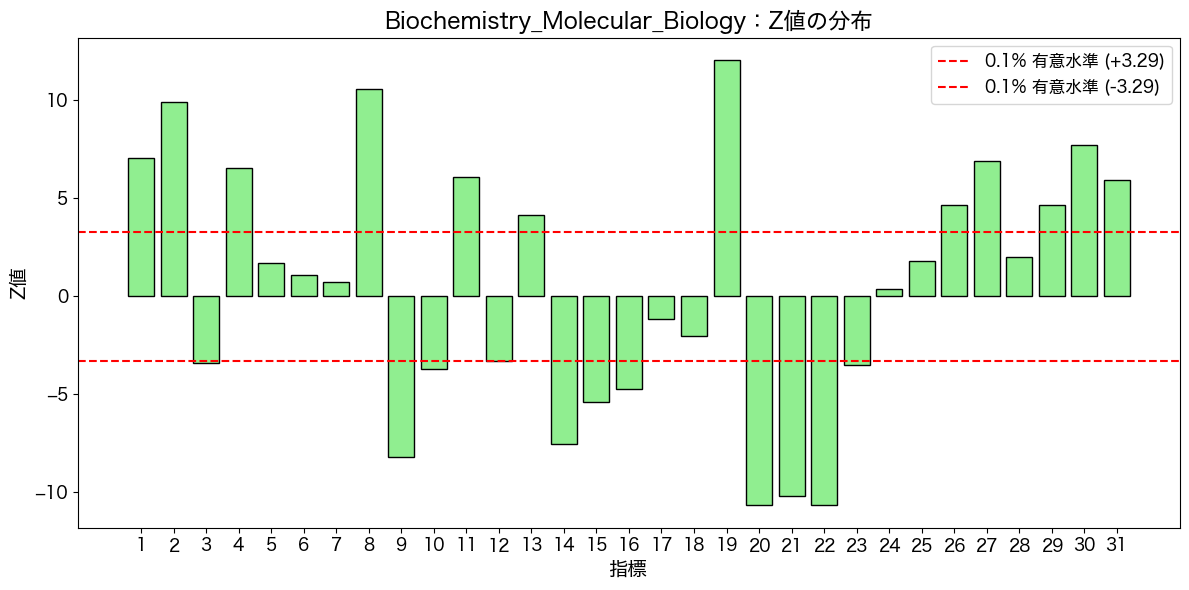

/var/folders/kb/fcmv44k11vvczn4k2qxly51c0000gn/T/ipykernel_71587/1402931054.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  field_subset['Rule'] = field_subset['Rule'].str.replace('rule', '').astype(int)


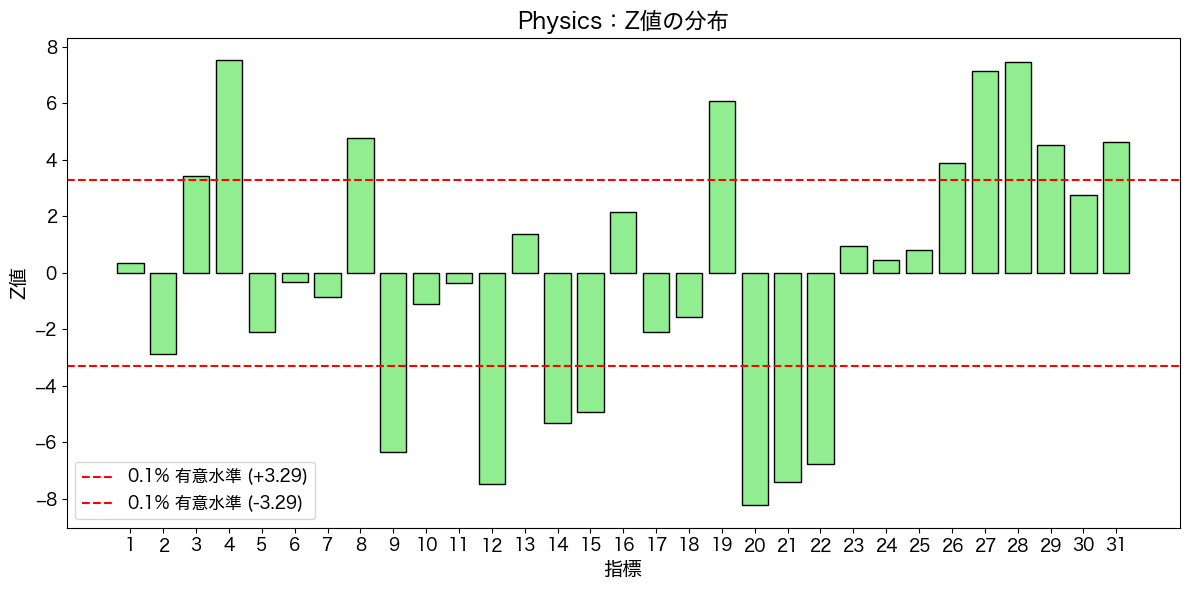

/var/folders/kb/fcmv44k11vvczn4k2qxly51c0000gn/T/ipykernel_71587/1402931054.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  field_subset['Rule'] = field_subset['Rule'].str.replace('rule', '').astype(int)


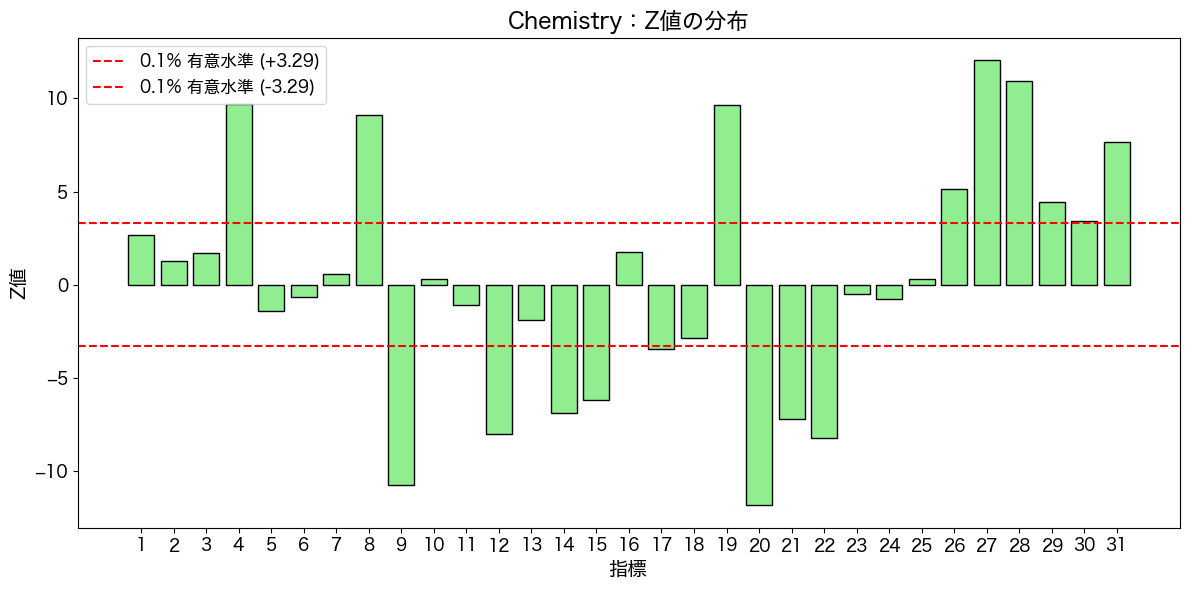

/var/folders/kb/fcmv44k11vvczn4k2qxly51c0000gn/T/ipykernel_71587/1402931054.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  field_subset['Rule'] = field_subset['Rule'].str.replace('rule', '').astype(int)


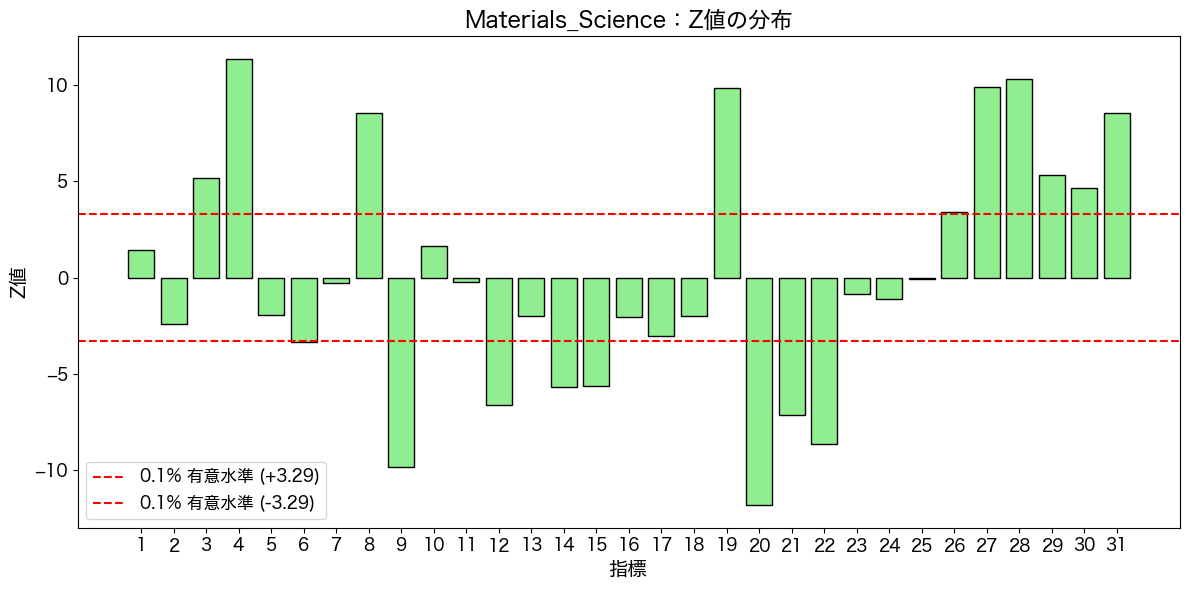

/var/folders/kb/fcmv44k11vvczn4k2qxly51c0000gn/T/ipykernel_71587/1402931054.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  field_subset['Rule'] = field_subset['Rule'].str.replace('rule', '').astype(int)


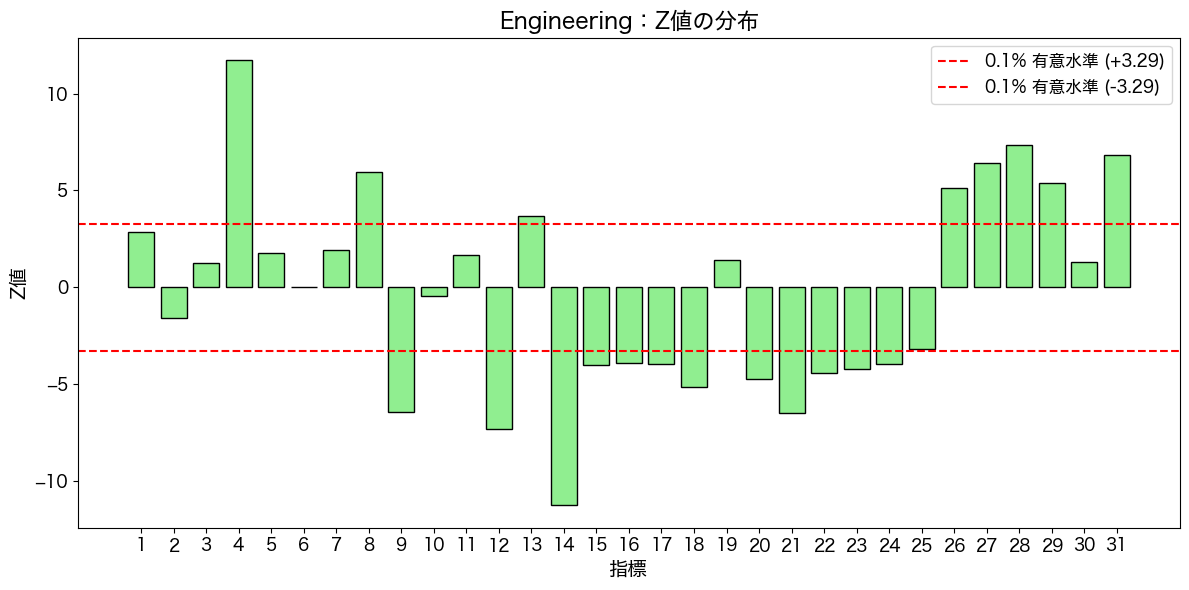

In [426]:
# 日本語フォントの設定
plt.rcParams['font.family'] = 'Hiragino Sans'

# 分野ごとにZ値をプロット
fields = field_df['Field'].unique()

for field in fields:
    # 分野ごとのデータを抽出
    field_subset = field_df[field_df['Field'] == field]
    
    # Rule列を数値化（横軸を数字のみにする）
    field_subset['Rule'] = field_subset['Rule'].str.replace('rule', '').astype(int)
    
    # グラフ作成
    plt.figure(figsize=(12, 6))
    plt.bar(field_subset['Rule'], field_subset['Z-statistic'], color='lightgreen', edgecolor='black')
    
    # 基準線の追加（有意水準 0.1% → Z値 ±3.29）
    plt.axhline(y=3.29, color='red', linestyle='--', label='0.1% 有意水準 (+3.29)')
    plt.axhline(y=-3.29, color='red', linestyle='--', label='0.1% 有意水準 (-3.29)')
    
    # 日本語ラベルの設定
    plt.title(f'{field}：Z値の分布', fontsize=16)
    plt.ylabel('Z値', fontsize=14)
    plt.xlabel('指標', fontsize=14)
    
    # x軸目盛りを数字のみにしてすべて表示
    plt.xticks(ticks=field_subset['Rule'], labels=field_subset['Rule'], fontsize=12, rotation=0)
    plt.yticks(fontsize=12)
    
    # 凡例の日本語化
    plt.legend(fontsize=12)
    
    # レイアウト調整
    plt.tight_layout()
    
    # グラフ表示
    plt.show()
